In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from qiskit import Aer, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.opflow import Z, I, StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient, PauliExpectation
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import  ZZFeatureMap, MCMT, RYGate
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit.library.standard_gates import HGate

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN, OpflowQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 42
hamiltonian = Z ^ I^ I ^ I^ I^ I^ I
#hamiltonian_TTN = I ^ Z^ I ^ I
#hamiltonianRed = Z ^ I ^ I
optimal_point1 = [0.77395605, 0.43887844, 0.85859792, 0.69736803, 0.09417735,
       0.97562235, 0.7611397 , 0.78606431, 0.12811363, 0.45038594,
       0.37079802, 0.92676499]

from auxData import Load_Data, Load_DataFull, plot_sampled_data_sepal, plot_predicted
from auxQuantum import FeatureMap, Neuron, TTN, FeatureMapFull, WeightlessNN


In [1]:
#Iris Dataset
dataset = pd.read_csv("data/iris.data")
dataset1 = dataset[dataset["class"] == "Iris-setosa"]
dataset2 = dataset[dataset["class"] == "Iris-versicolor"]
dataset3 = dataset[dataset["class"] == "Iris-virginica"]
dataset1_train, dataset1_test = train_test_split(dataset1, test_size=0.33, random_state=25)
dataset2_train, dataset2_test = train_test_split(dataset2, test_size=0.33, random_state=25)
dataset3_train, dataset3_test = train_test_split(dataset3, test_size=0.33, random_state=25)
dataset_list_train = [dataset1_train, dataset2_train, dataset3_train]
dataset_list_test = [dataset1_test, dataset2_test, dataset3_test]
dataset.head(5)

NameError: name 'pd' is not defined

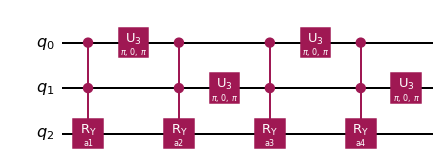

In [3]:
test = QuantumCircuit(3)
test.append(Neuron("a1", "a2", "a3", "a4"), [0,1,2])
test.decompose().decompose().draw('mpl', style='iqx')

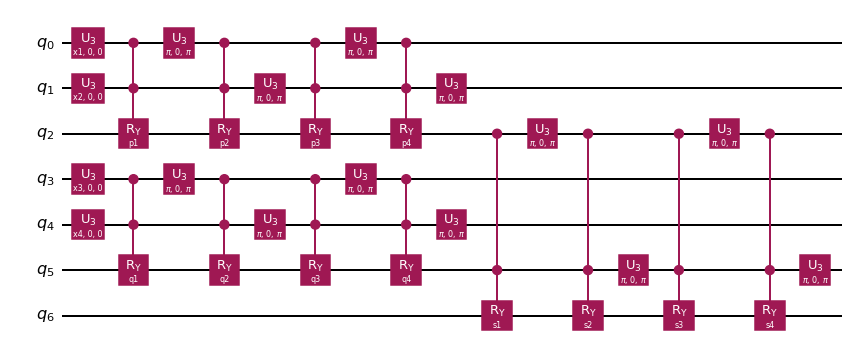

In [4]:
qc_final = QuantumCircuit(7)
FeatureMapCircuit = FeatureMapFull()
qc_final.append(FeatureMapCircuit, [0,1,3,4])
qc_final.decompose().draw('mpl', style='iqx')
Ansatz = WeightlessNN()
#Ansatz = TTN()
qc_final.append(Ansatz, [0,1,2,3,4,5,6])
qc_final.decompose().decompose().decompose().draw('mpl', style='iqx')

In [5]:
training_features, training_labels, test_features, test_labels = Load_DataFull(1,2, dataset_list_train,dataset_list_test )

class
Iris-setosa        33
Iris-versicolor    33
dtype: int64
class
Iris-setosa        17
Iris-versicolor    17
dtype: int64


In [6]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [7]:
from qiskit.algorithms.optimizers import GradientDescent
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)
gd_qnn_loss = []
def gd_qnn_callback(*args):
    gd_qnn_loss.append(args[2])
    
gd = GradientDescent(maxiter=100, learning_rate=0.01, callback=gd_qnn_callback)
qnn_expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(qc_final)

qnn = OpflowQNN(qnn_expectation, 
                input_params=list(FeatureMapCircuit.parameters), 
                weight_params=list(Ansatz.parameters),
                exp_val=PauliExpectation(),
                gradient=Gradient(),  
                quantum_instance=quantum_instance)

In [8]:
opflow_classifier = NeuralNetworkClassifier(qnn, optimizer=COBYLA(), callback=callback_graph, initial_point = optimal_point1)


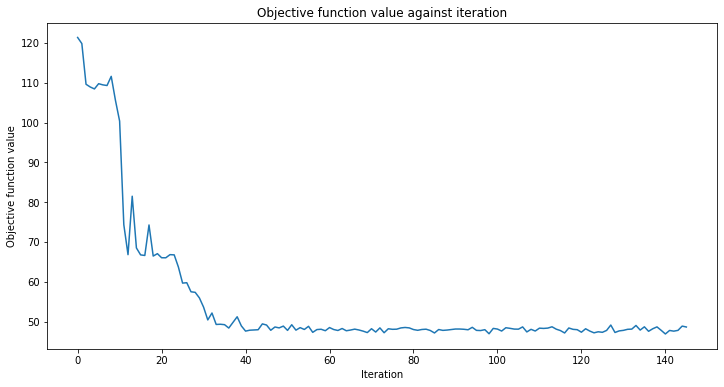

0.8181818181818182

In [9]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(training_features, training_labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(training_features, training_labels)

Obs: mesmo fixando o ponto inicial, a performance varia

Wrong predicted: 9


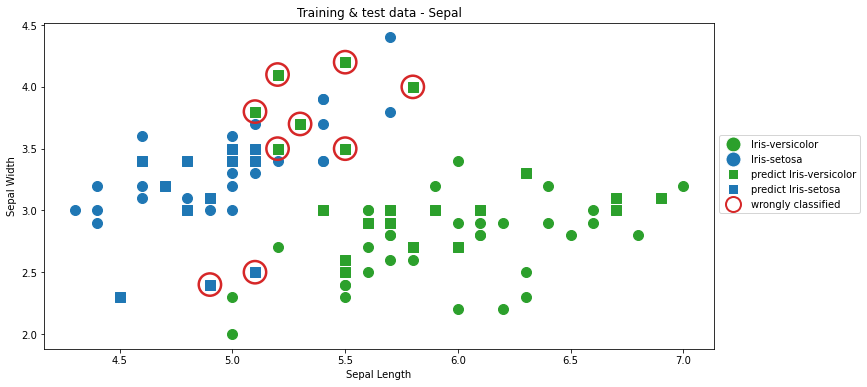

In [10]:
predicted = opflow_classifier.predict(test_features)

def plot_predicted(a,b, training_features, training_labels, test_features, test_labels):
    from matplotlib.lines import Line2D
    wrong_predicted = 0
    plt.figure(figsize=(12, 6))
    label_train = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    label_test = ['predict Iris-setosa', 'predict Iris-versicolor', 'predict Iris-virginica']
    for feature, label in zip(training_features, training_labels):
        marker = 'o' 
        color = 'tab:green' if label == -1 else 'tab:blue'
        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    for feature, label, pred in zip(test_features, test_labels, predicted):
        marker = 's' 
        color = 'tab:green' if pred == -1 else 'tab:blue'
        if label != pred:  # mark wrongly classified
            wrong_predicted+=1
            plt.scatter(feature[0], feature[1], marker='o', s=500, linewidths=2.5,
                        facecolor='none', edgecolor='tab:red')

        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    legend_elements = [
        Line2D([0], [0], marker='o', c='w', mfc='tab:green', label=label_train[b-1], ms=15),
        Line2D([0], [0], marker='o', c='w', mfc='tab:blue', label=label_train[a-1], ms=15),
        Line2D([0], [0], marker='s', c='w', mfc='tab:green', label=label_test[b-1], ms=10),
        Line2D([0], [0], marker='s', c='w', mfc='tab:blue', label=label_test[a-1], ms=10),
        Line2D([0], [0], marker='o', c='w', mfc='none', mec='tab:red', label='wrongly classified', mew=2, ms=15)
    ]

    plt.legend(loc= "lower left", handles=legend_elements, bbox_to_anchor=(1.0, 0.4))
    plt.title('Training & test data - Sepal')
    plt.xlabel('Sepal Length')
    plt.ylabel('Sepal Width')
    print("Wrong predicted:", wrong_predicted)
    
plot_predicted(1,2,training_features, training_labels, test_features, test_labels)

In [11]:
test2_col1 = np.random.uniform(low=2.0, high=4.25, size=(100,))
test2_col2 = np.random.uniform(low=4.0, high=7.0, size=(100,))
test2_col3 = np.random.uniform(low=2.0, high=4.25, size=(100,))
test2_col4 = np.random.uniform(low=4.0, high=7.0, size=(100,))
test2= np.vstack((test2_col4, test2_col3, test2_col2, test2_col1)).T

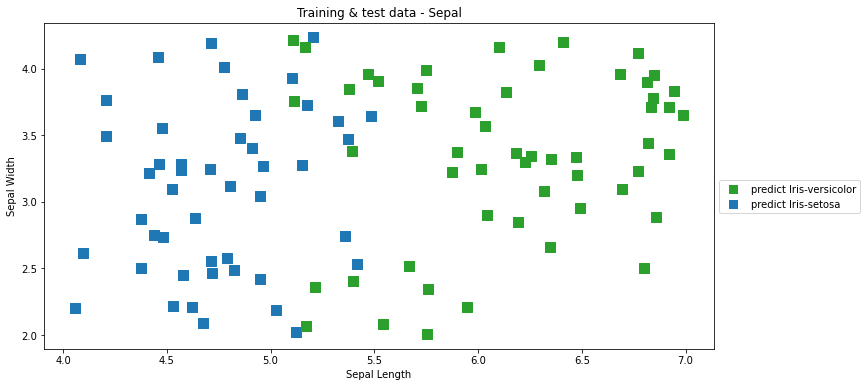

In [12]:
predicted = opflow_classifier.predict(test2)
def plot_area(a,b, test_features):
    from matplotlib.lines import Line2D
    wrong_predicted = 0
    plt.figure(figsize=(12, 6))
    label_train = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    label_test = ['predict Iris-setosa', 'predict Iris-versicolor', 'predict Iris-virginica']
    
    for feature, pred in zip(test_features, predicted):
        marker = 's' 
        color = 'tab:green' if pred == -1 else 'tab:blue'
        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    legend_elements = [

        Line2D([0], [0], marker='s', c='w', mfc='tab:green', label=label_test[b-1], ms=10),
        Line2D([0], [0], marker='s', c='w', mfc='tab:blue', label=label_test[a-1], ms=10),

    ]

    plt.legend(loc= "lower left", handles=legend_elements, bbox_to_anchor=(1.0, 0.4))
    plt.title('Training & test data - Sepal')
    plt.xlabel('Sepal Length')
    plt.ylabel('Sepal Width')
plot_area(1,2, test2)

Comportamento bizarro. Ele não respeita as regiões de decisão. Pode ser problema no meu teste, ou o classificador é bizarro

Esse aqui foi o melhor ponto inicial testado (Score = 1)

In [13]:
opflow_classifier.initial_point 

[0.77395605,
 0.43887844,
 0.85859792,
 0.69736803,
 0.09417735,
 0.97562235,
 0.7611397,
 0.78606431,
 0.12811363,
 0.45038594,
 0.37079802,
 0.92676499]

Cópia do ponto inicial ótimo

In [14]:
[0.77395605, 0.43887844, 0.85859792, 0.69736803, 0.09417735,
       0.97562235, 0.7611397 , 0.78606431, 0.12811363, 0.45038594,
       0.37079802, 0.92676499]

[0.77395605,
 0.43887844,
 0.85859792,
 0.69736803,
 0.09417735,
 0.97562235,
 0.7611397,
 0.78606431,
 0.12811363,
 0.45038594,
 0.37079802,
 0.92676499]

## Fazendo o mesmo para as outras classes. Começamos com a 1 e 3

In [22]:
training_features, training_labels, test_features, test_labels = Load_DataFull(1,3, dataset_list_train,dataset_list_test )

class
Iris-setosa       33
Iris-virginica    33
dtype: int64
class
Iris-setosa       17
Iris-virginica    17
dtype: int64


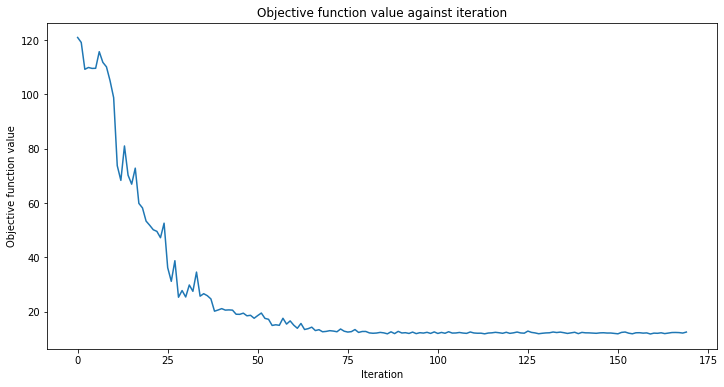

1.0

In [23]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(training_features, training_labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(training_features, training_labels)

Wrong predicted: 1


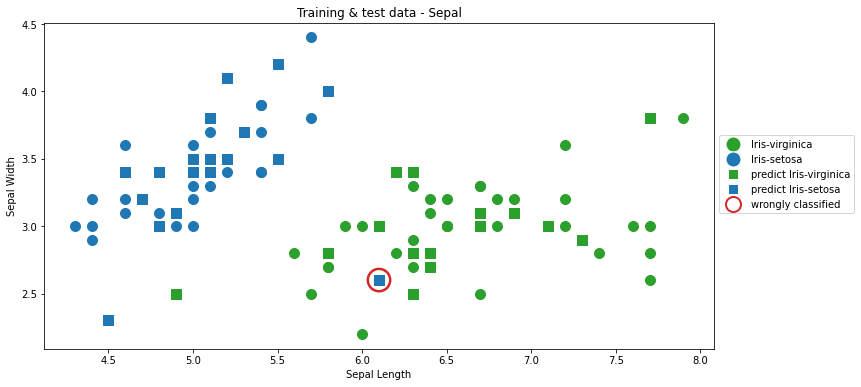

In [24]:
predicted = opflow_classifier.predict(test_features)
plot_predicted(1,3,training_features, training_labels, test_features, test_labels)

## Classes 2 e 3

In [25]:
training_features, training_labels, test_features, test_labels = Load_DataFull(2,3, dataset_list_train,dataset_list_test )

class
Iris-versicolor    33
Iris-virginica     33
dtype: int64
class
Iris-versicolor    17
Iris-virginica     17
dtype: int64


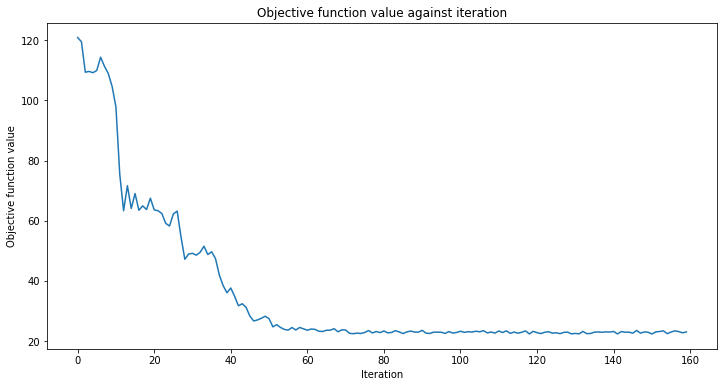

0.9696969696969697

In [26]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(training_features, training_labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(training_features, training_labels)

Wrong predicted: 4


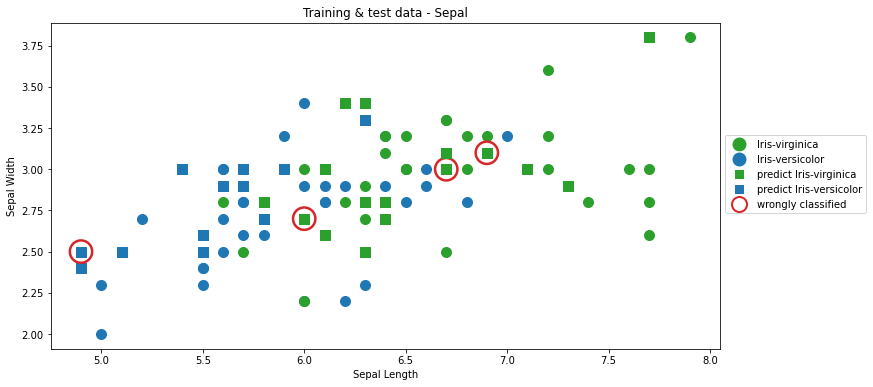

In [27]:
predicted = opflow_classifier.predict(test_features)
plot_predicted(2,3,training_features, training_labels, test_features, test_labels)